In [1]:
# Import librarys
from run_ac import *
import os
from tqdm import tqdm
import time
from func import *
import geopandas as gpd
from matplotlib import pyplot as plt
from scipy import stats

## Load and prepare data

In [2]:
# Read in forcing data
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])

# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

In [3]:
# Replace the timestamp from LAI
new_time_range = pd.date_range(start='2000-01-01', end='2023-12-31', freq='D')
lai_data['time'] = new_time_range

# Replace first 48 days with them from 2001
torep = lai_data.sel(time = slice("2001-01-01","2001-02-17"))
lai_data.values[0:48, :, :] = torep.values

# Fill gaps in LAI
for lat in range(len(P_data.lat)):
    for lon in range(len(P_data.lon)):
        if np.isnan(lai_data[:, lat, lon]).all():
            continue
        else:
            # Get the data for the current grid cell
            grid_cell_data = lai_data[:, lat, lon]
            
            # Convert to DataFrame for easier handling
            grid_cell_df = pd.DataFrame(grid_cell_data)
            
            # Fill NA values with the previous value
            grid_cell_df.fillna(method='ffill', inplace=True)
            
            # Update the grid cell data
            lai_data[:, lat, lon] = grid_cell_df.values.flatten()

C:\Users\motze\AppData\Local\Temp\ipykernel_1432\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_1432\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_1432\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ffill', inplace=True)
C:\Users\motze\AppData\Local\Temp\ipykernel_1432\3949883917.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  grid_cell_df.fillna(method='ff

## Detrend T and R

In [4]:
def detrend_temp(data):
    time = np.arange(len(data))
    slope, intercept, _, _, _ = stats.linregress(time, data)
    detrended_values = data - (time * slope)
    return detrended_values

In [5]:
# Apply the function to each grid cell
T_detrend = xr.apply_ufunc(
    detrend_temp,
    T_data,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [6]:
R_detrend = xr.apply_ufunc(
    detrend_temp,
    R_data,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

## Multiply trend

In [7]:
def calc_temp(data, multiplier=2):
    time = np.arange(len(data))
    slope, intercept, _, _, _ = stats.linregress(time, data)
    new_values = time * slope * multiplier
    return data + new_values, slope

In [27]:
# Apply the function to each grid cell
T_multiplied, mean_slopes_T = xr.apply_ufunc(
    calc_temp,
    T_data,
    input_core_dims=[['time']],
    output_core_dims=[['time'], []],  # Return an extra dimension for the slopes
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float],
    kwargs={'multiplier': 2}
)

In [87]:
mean_slopes_T.mean()

<xarray.DataArray 't2m' ()> Size: 8B
array(0.00015789)

In [28]:
# Apply the function to each grid cell
R_multiplied, mean_slopes_R = xr.apply_ufunc(
    calc_temp,
    R_data,
    input_core_dims=[['time']],
    output_core_dims=[['time'], []],  # Return an extra dimension for the slopes
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float],
    kwargs={'multiplier': 2}
)

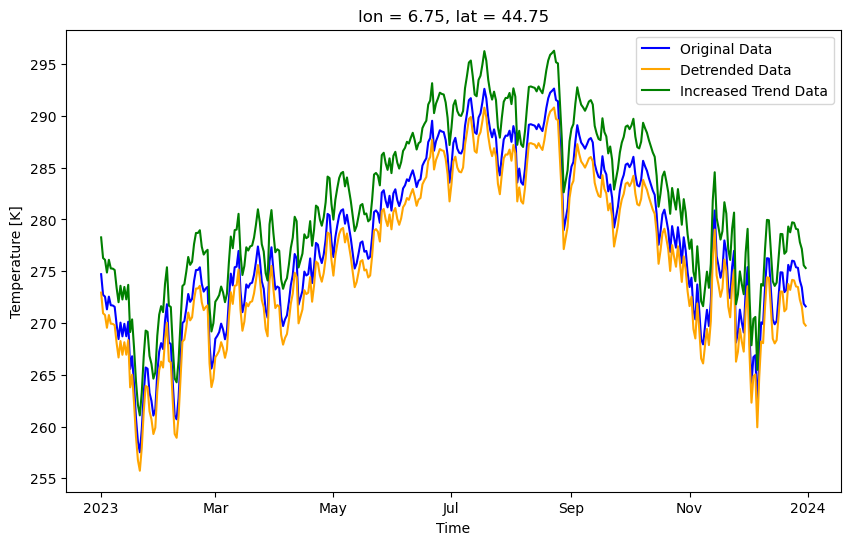

In [68]:
plt.figure(figsize=(10, 6))
T_data.sel(time='2023').isel(lat=21, lon=4).plot(x='time',
                                                 label='Original Data',
                                                 color = 'blue')
T_detrend.sel(time='2023').isel(lat=21, lon=4).plot(x='time',
                                                    label='Detrended Data',
                                                    color = 'orange')
T_multiplied.sel(time='2023').isel(lat=21, lon=4).plot(x='time',
                                                       label='Increased Trend Data',
                                                       color = 'green')
plt.xlabel('Time')
plt.ylabel('Temperature [K]')
plt.legend()
plt.show()

## Run models

In [13]:
# Prepare data for model
full_data = np.full((22, 22, 8766, 4), np.nan)
#full_data = np.zeros((22, 22, 8766, 4))

full_data[:, :, :, 0] = P_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 1] = R_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 3] = lai_data.transpose('latitude', 'longitude', 'time')

# Prepare model
params = [420, 8, 0.2, 0.8, 1.5, (0.75, 0.25)]

In [14]:
# Run model for original data
original = out2xarray(time_evolution(full_data, *params))

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 6946.09it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

## Detrend

In [15]:
# Run model for detrended data
full_data[:, :, :, 1] = R_detrend.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_detrend.transpose('lat', 'lon', 'time')

detrend = out2xarray(time_evolution(full_data, *params))


c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 7515.34it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

In [24]:
# Run model for detrended data only T detrended
full_data[:, :, :, 1] = R_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_detrend.transpose('lat', 'lon', 'time')

detrend_T = out2xarray(time_evolution(full_data, *params))


c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 5936.00it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

In [25]:
# Run model for detrended data only R detrended
full_data[:, :, :, 1] = R_detrend.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_data.transpose('lat', 'lon', 'time')

detrend_R = out2xarray(time_evolution(full_data, *params))


c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 4851.20it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

## Increased trends

In [16]:
# Run model for increased trend data
full_data[:, :, :, 1] = R_multiplied.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_multiplied.transpose('lat', 'lon', 'time')

multiplied = out2xarray(time_evolution(full_data, *params))

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 7845.22it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

In [23]:
# Run model for increased trend data only T increased
full_data[:, :, :, 1] = R_data.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_multiplied.transpose('lat', 'lon', 'time')

multiplied_T = out2xarray(time_evolution(full_data, *params))

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 7497.41it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

In [22]:
# Run model for increased trend data only T increased
full_data[:, :, :, 1] = R_multiplied.transpose('lat', 'lon', 'time')
full_data[:, :, :, 2] = T_data.transpose('lat', 'lon', 'time')

multiplied_R = out2xarray(time_evolution(full_data, *params))

c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:35: RuntimeWarning: invalid value encountered in divide
  normalized_lai = (lai - lai_min) / (lai_max - lai_min)


start_timeevolution


100%|██████████| 8766/8766 [00:01<00:00, 8167.44it/s]
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  out_xr = xr.DataArray(output[:, :, :, i], dims=('time', 'lat', 'lon'),
c:\Users\motze\OneDrive\Master\ALM\MSC24-WBM\run_ac.py:127: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.dateti

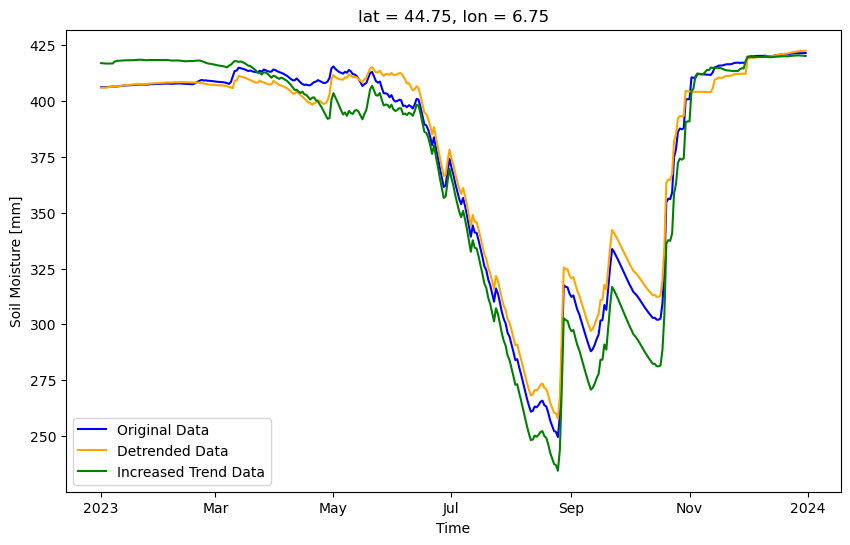

In [67]:
plt.figure(figsize=(10, 6))
original['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time', 
                                                                    label='Original Data',
                                                                    color = 'blue')
detrend['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time',
                                                                   label='Detrended Data',
                                                                   color = 'orange')
multiplied['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time',
                                                                      label='Increased Trend Data',
                                                                      color = 'green')

plt.xlabel('Time')
plt.ylabel('Soil Moisture [mm]')
plt.legend()
plt.show()

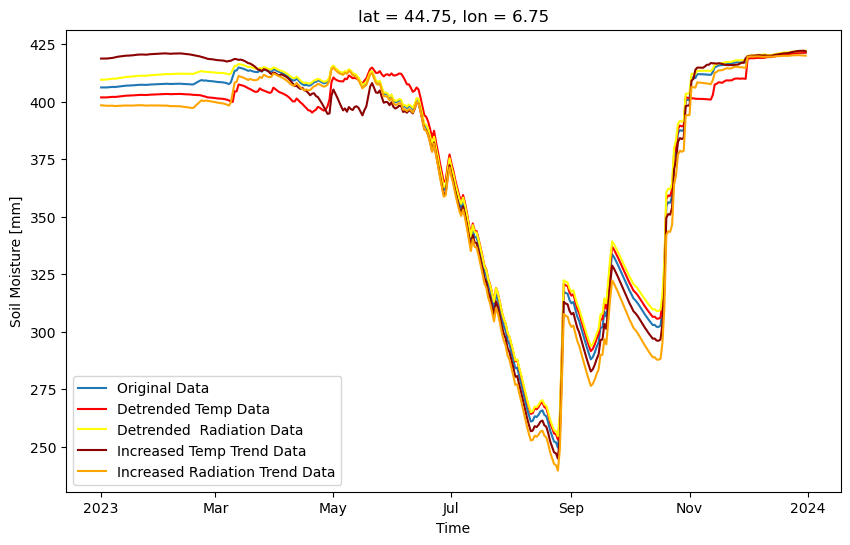

In [66]:
plt.figure(figsize=(10, 6))
original['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time', 
                                                                    label='Original Data')
detrend_T['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time', 
                                                                     label='Detrended Temp Data',
                                                                     color = 'red')
detrend_R['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time', 
                                                                     label='Detrended  Radiation Data',
                                                                     color = 'yellow')
multiplied_T['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time', 
                                                                        label='Increased Temp Trend Data',
                                                                        color = 'darkred')
multiplied_R['soil_moisture'].sel(time='2023').isel(lat=21, lon=4).plot(x='time', 
                                                                        label='Increased Radiation Trend Data',
                                                                        color = 'orange')

plt.xlabel('Time')
plt.ylabel('Soil Moisture [mm]')
plt.legend()
plt.show()

* Both trends together have the biggest effect
* Radiation has bigger impact than temperature

## Results

In [39]:
diffrence_D = original - detrend
diffrence_M = multiplied - detrend


C:\Users\motze\AppData\Local\Temp\ipykernel_1432\1519328301.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


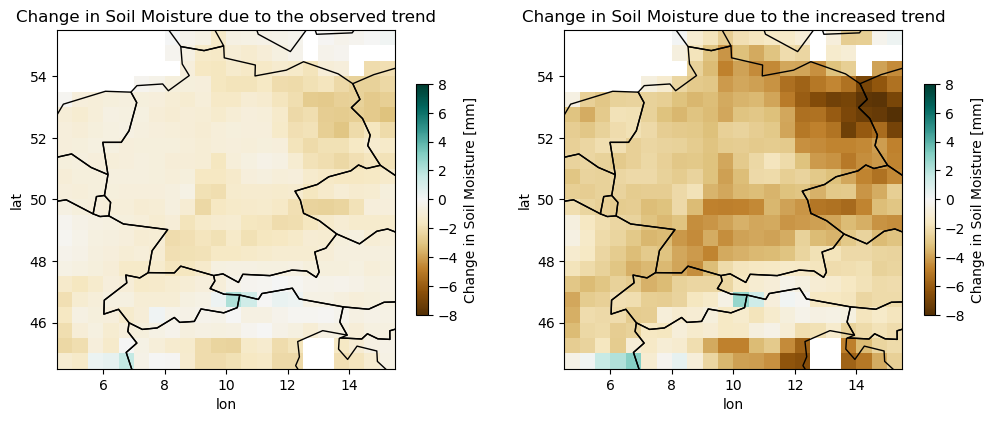

In [69]:
# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the mean soil moisture for the present in the second subplot
im2 = diffrence_D['soil_moisture'].mean(dim='time').plot(ax=axs[0], cmap = 'BrBG', vmin = -8, vmax = 8)
axs[0].set_title('Change in Soil Moisture due to the observed trend')

# Plot the mean soil moisture for the future in the first subplot
im1 = diffrence_M['soil_moisture'].mean(dim='time').plot(ax=axs[1], cmap = 'BrBG', vmin = -8, vmax = 8)
axs[1].set_title('Change in Soil Moisture due to the increased trend')

# Remove colorbars
for ax in axs:
    ax.collections[0].colorbar.remove()
cbar1 = plt.colorbar(im2, ax=axs[0], shrink=0.5, cmap = 'BrBG')
cbar1.set_label('Change in Soil Moisture [mm]')

cbar2 = plt.colorbar(im1, ax=axs[1], shrink=0.5)
cbar2.set_label('Change in Soil Moisture [mm]')

# Plot country boundaries
world.boundary.plot(ax=axs[0], linewidth=1, color = 'black')
world.boundary.plot(ax=axs[1], linewidth=1, color = 'black')

plt.show()

In [70]:
original_mean = original.mean(dim='time')

In [82]:
D_per = (diffrence_D / original_mean)*100
M_per = (diffrence_M / original_mean)*100

C:\Users\motze\AppData\Local\Temp\ipykernel_1432\2901304377.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


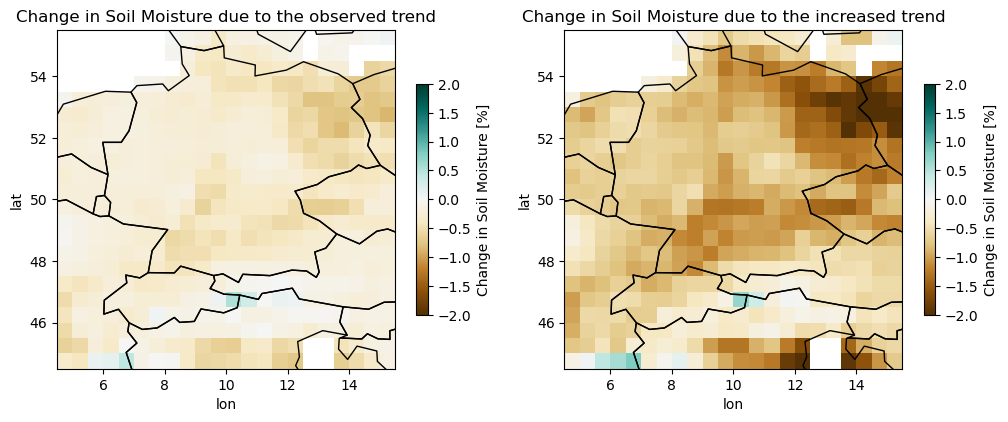

In [86]:
# Load country boundaries shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the mean soil moisture for the present in the second subplot
im2 = D_per['soil_moisture'].mean(dim='time').plot(ax=axs[0], cmap = 'BrBG', vmin = -2, vmax = 2)
axs[0].set_title('Change in Soil Moisture due to the observed trend')

# Plot the mean soil moisture for the future in the first subplot
im1 = M_per['soil_moisture'].mean(dim='time').plot(ax=axs[1], cmap = 'BrBG', vmin = -2, vmax = 2)
axs[1].set_title('Change in Soil Moisture due to the increased trend')

# Remove colorbars
for ax in axs:
    ax.collections[0].colorbar.remove()
cbar1 = plt.colorbar(im2, ax=axs[0], shrink=0.5, cmap = 'BrBG')
cbar1.set_label('Change in Soil Moisture [%]')

cbar2 = plt.colorbar(im1, ax=axs[1], shrink=0.5)
cbar2.set_label('Change in Soil Moisture [%]')

# Plot country boundaries
world.boundary.plot(ax=axs[0], linewidth=1, color = 'black')
world.boundary.plot(ax=axs[1], linewidth=1, color = 'black')

plt.show()

## Seasons

In [89]:
#seasonal_data = split_seasons(current)
seasonal_original = split_seasons(original)

NameError: name 'func' is not defined